In [9]:
import torch
import torch.nn as nn
from tokenizers import Tokenizer, models, trainers
from tokenizers.pre_tokenizers import Whitespace
import torch.optim as optim
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [10]:
corpus = [
    "daisy rose flower",
    "apple banana fruit",
    "daisy apple rose banana",
    "flower fruit",
]

In [11]:
with open("corpus_1.txt", "w", encoding="utf-8") as f:
    for line in corpus:
        f.write(line + "\n")

In [12]:
# Train BPE Tokenizer
tokenizer = Tokenizer(models.BPE())
tokenizer.pre_tokenizers = Whitespace()
trainer = trainers.BpeTrainer(
    vocab_size=100, show_progress=True, special_tokens=["[UNK]", "[CLS]", "[SEP]"]
)
tokenizer.train(["corpus_1.txt"], trainer)

output = tokenizer.encode("laptop daisy mobile")
print("TOKENS : ", output.tokens)
print("TOKEN_ids : ", output.ids)

TOKENS :  ['l', 'ap', 't', 'o', 'p', ' ', 'daisy ', 'o', 'b', 'i', 'l', 'e']
TOKEN_ids :  [12, 27, 18, 14, 15, 5, 49, 14, 7, 11, 12, 9]


In [13]:
# Embeddings
vocab_size = tokenizer.get_vocab_size()
embed_dim = 8
embedding = nn.Embedding(vocab_size, embed_dim)
token_ids = torch.tensor(output.ids)
embeds = embedding(token_ids)

print("Embeddding Shape :", embeds.shape)
print("Sample Embeddibngs:\n", embeds)

Embeddding Shape : torch.Size([12, 8])
Sample Embeddibngs:
 tensor([[ 0.4517,  0.4428, -1.8726,  0.1782, -0.6954,  0.2871,  1.2312,  1.3384],
        [-0.9488,  0.1515, -1.1563, -0.3745,  1.5068,  0.4685, -1.2092,  0.3495],
        [ 0.7271, -0.1219, -1.3274, -1.0547, -0.0120,  1.3648,  1.4148, -0.1798],
        [ 0.3703,  0.6249,  0.3065,  0.6430, -0.6678,  2.4243, -1.4817,  0.4181],
        [ 0.7956,  0.5431, -0.3435, -1.2150, -1.7040,  0.3059,  0.1214,  0.2259],
        [-1.5271, -0.7894,  0.5503, -0.6082, -1.1125, -0.0170, -0.4116, -0.3025],
        [-0.8338, -0.4310,  0.7411, -0.0799, -0.2930,  2.6187,  1.9263,  1.2725],
        [ 0.3703,  0.6249,  0.3065,  0.6430, -0.6678,  2.4243, -1.4817,  0.4181],
        [ 0.5359,  0.4983,  1.3714,  1.3350,  0.2468,  0.7520, -0.7167, -0.8192],
        [-2.0004,  1.2392,  1.2211, -1.2742, -0.1668,  1.3150,  1.5938, -1.7983],
        [ 0.4517,  0.4428, -1.8726,  0.1782, -0.6954,  0.2871,  1.2312,  1.3384],
        [-0.4782,  0.2394, -0.7476, -0

In [14]:
# Transfomer
class MiniTransfomer(nn.Module):
    def __init__(self, embed_dim, num_heads=2):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, embed_dim), nn.ReLU(), nn.Linear(embed_dim, embed_dim)
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # seq length , batch , embed_dim
        attn_out, _ = self.attn(x, x, x)
        x = attn_out + x  # residual
        x = self.ff(x) + x
        return x.squeeze(1)


model = MiniTransfomer(embed_dim)

In [15]:
# Training loop
optimizer = optim.Adam(list(model.parameters()) + list(embedding.parameters()), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(10):
    optimizer.zero_grad()

    # recomute embeddings each epoch
    embeds = embedding(token_ids)
    inputs = embeds[:-1]
    targets = token_ids[1:]

    out = model(inputs)
    logits = out @ embedding.weight.T
    loss = loss_fn(logits, targets)

    loss.backward()
    optimizer.step()

    print(f"\n Epoch {epoch}")
    print("Transformer Output shape: ", out.shape)
    print("logits  shape: ", logits.shape)
    print("loss:", loss.item())


 Epoch 0
Transformer Output shape:  torch.Size([11, 8])
logits  shape:  torch.Size([11, 61])
loss: 8.6563081741333

 Epoch 1
Transformer Output shape:  torch.Size([11, 8])
logits  shape:  torch.Size([11, 61])
loss: 8.245206832885742

 Epoch 2
Transformer Output shape:  torch.Size([11, 8])
logits  shape:  torch.Size([11, 61])
loss: 7.890523910522461

 Epoch 3
Transformer Output shape:  torch.Size([11, 8])
logits  shape:  torch.Size([11, 61])
loss: 7.576089382171631

 Epoch 4
Transformer Output shape:  torch.Size([11, 8])
logits  shape:  torch.Size([11, 61])
loss: 7.2833571434021

 Epoch 5
Transformer Output shape:  torch.Size([11, 8])
logits  shape:  torch.Size([11, 61])
loss: 7.00439453125

 Epoch 6
Transformer Output shape:  torch.Size([11, 8])
logits  shape:  torch.Size([11, 61])
loss: 6.728967189788818

 Epoch 7
Transformer Output shape:  torch.Size([11, 8])
logits  shape:  torch.Size([11, 61])
loss: 6.452325820922852

 Epoch 8
Transformer Output shape:  torch.Size([11, 8])
logits 

) missing from font(s) DejaVu Sans.\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


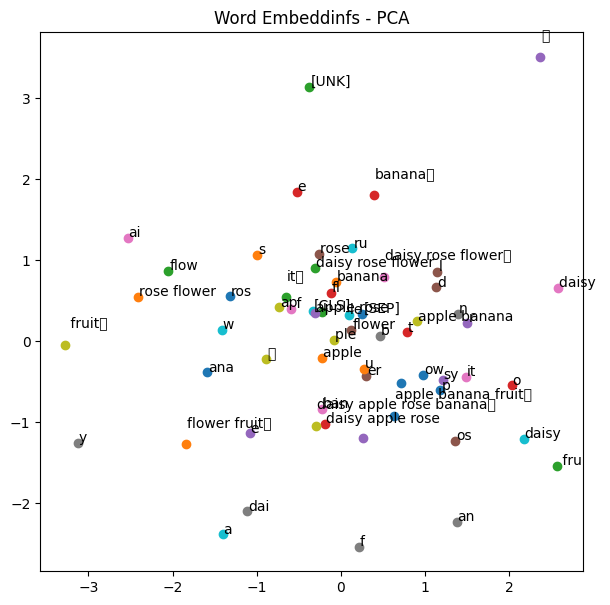

In [16]:
# Visulaize

final_embeds = embedding.weight.detach().numpy()

pca = PCA(n_components=2).fit_transform(final_embeds)

plt.figure(figsize=(7, 7))

for word, idx in tokenizer.get_vocab().items():
    plt.scatter(pca[idx, 0], pca[idx, 1])
    plt.text(pca[idx, 0] + 0.01, pca[idx, 1] + 0.01, word)
    plt.title("Word Embeddinfs - PCA")
plt.show()
